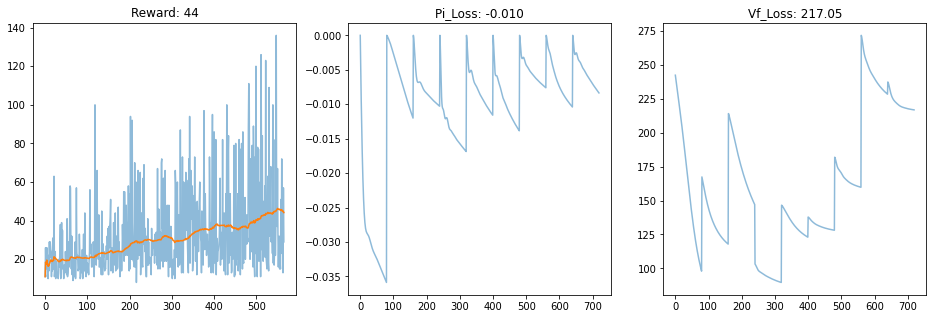

In [ ]:
import random
import numpy as np
import torch
from torch.optim import Adam, AdamW
import gym
import time
import core
import matplotlib.pyplot as plt
from IPython.display import clear_output
from running_mean_std import RunningMeanStd


class PPOBuffer(object):
    def __init__(self, obs_dim, act_dim, size, gamma=0.999, lam=0.97):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = core.discount_cumsum(deltas, self.gamma * self.lam)
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]
        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size
        self.ptr, self.path_start_idx = 0, 0
        adv_mean = np.mean(self.adv_buf)
        adv_std = np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}



def plot(ep_ret_buf, eval_ret_buf, loss_buf):
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(131)
    plt.plot(ep_ret_buf, alpha=0.5)
    plt.subplot(131)
    plt.plot(eval_ret_buf)
    plt.title(f"Reward: {eval_ret_buf[-1]:.0f}")
    plt.subplot(132)
    plt.plot(loss_buf['pi'], alpha=0.5)
    plt.title(f"Pi_Loss: {np.mean(loss_buf['pi'][:-10:]):.3f}")
    plt.subplot(133)
    plt.plot(loss_buf['vf'], alpha=0.5)
    plt.title(f"Vf_Loss: {np.mean(loss_buf['vf'][-10:]):.2f}")
    plt.show()



def compute_loss_pi(data, ac, beta):
    obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

    # Policy loss
    pi, logp = ac.pi(obs, act)
    ratio = torch.exp(logp - logp_old)
    kl_div = logp.exp() * (logp - logp_old)
    loss_pi = -(ratio * adv - beta * kl_div).mean()

    # Useful extra info
    kl = ((logp.exp() * (logp - logp_old)).mean()).detach().item()
    ent = pi.entropy().mean().detach().item()
    pi_info = dict(kl=kl, ent=ent)
    return loss_pi, pi_info

def compute_loss_v(data, ac):
    obs, ret = data['obs'], data['ret']
    return ((ac.v(obs) - ret)**2).mean()


def update(buf, train_pi_iters, train_vf_iters, beta, target_kl, ac, pi_optimizer, vf_optimizer, loss_buf):
    data = buf.get()

    # Train policy with multiple steps of gradient descent
    for i in range(train_pi_iters):
        pi_optimizer.zero_grad()
        loss_pi, pi_info = compute_loss_pi(data, ac, beta)
        loss_buf['pi'].append(loss_pi.item())
        loss_pi.backward()
        pi_optimizer.step()

    # Value function learning
    for i in range(train_vf_iters):
        vf_optimizer.zero_grad()
        loss_vf = compute_loss_v(data, ac)
        loss_buf['vf'].append(loss_vf.item())
        loss_vf.backward()
        vf_optimizer.step()



def main():
    actor_critic = core.MLPActorCritic
    hidden_size = 64
    activation = torch.nn.Tanh
    seed = 5
    steps_per_epoch = 2048
    epochs = 1000
    gamma = 0.999
    lam = 0.97
    beta = 3.0
    pi_lr = 3e-4
    vf_lr = 2e-5
    train_pi_iters = 80
    train_vf_iters = 80
    max_ep_len = 1000
    target_kl = 0.01
    save_freq = 10
    obs_norm = True
    view_curve = True

    # make an environment
#     env = gym.make('CartPole-v0')
    env = gym.make('CartPole-v1')
#     env = gym.make('MountainCar-v0')
#     env = gym.make('LunarLander-v2')
#     env = gym.make('BipedalWalker-v3')
    print(f"reward_threshold: {env.spec.reward_threshold}")

    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape

    # Random seed
    env.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Create actor-critic module
    ac = actor_critic(env.observation_space, env.action_space, (hidden_size, hidden_size), activation)
    
    # Set up optimizers for policy and value function
    pi_optimizer = AdamW(ac.pi.parameters(), lr=pi_lr, eps=1e-6)
    vf_optimizer = AdamW(ac.v.parameters(), lr=vf_lr, eps=1e-6)

    # Count variables
    var_counts = tuple(core.count_vars(module) for module in [ac.pi, ac.v])

    # Set up experience buffer
    local_steps_per_epoch = int(steps_per_epoch)
    buf = PPOBuffer(obs_dim, act_dim, local_steps_per_epoch, gamma, lam)
    
    # Prepare for interaction with environment
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0
    ep_num = 0
    ep_ret_buf, eval_ret_buf = [], []
    loss_buf = {'pi': [], 'vf': []}
    obs_normalizer = RunningMeanStd(shape=env.observation_space.shape)
    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        for t in range(local_steps_per_epoch):
#             env.render()
            if obs_norm:
                obs_normalizer.update(np.array([o]))
                o_norm = np.clip((o - obs_normalizer.mean) / np.sqrt(obs_normalizer.var), -10, 10)
                a, v, logp = ac.step(torch.as_tensor(o_norm, dtype=torch.float32))
            else:
                a, v, logp = ac.step(torch.as_tensor(o, dtype=torch.float32))

            next_o, r, d, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            # save and log
            if obs_norm:
                buf.store(o_norm, a, r, v, logp)
            else:
                buf.store(o, a, r, v, logp)

            # Update obs
            o = next_o

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t==local_steps_per_epoch-1

            if terminal or epoch_ended:
                if timeout or epoch_ended:
                    if obs_norm:
                        obs_normalizer.update(np.array([o]))
                        o_norm = np.clip((o - obs_normalizer.mean) / np.sqrt(obs_normalizer.var), -10, 10)
                        _, v, _ = ac.step(torch.as_tensor(o_norm, dtype=torch.float32))
                    else:
                        _, v, _ = ac.step(torch.as_tensor(o, dtype=torch.float32))
                else:
                    if obs_norm:
                        obs_normalizer.update(np.array([o]))
                    v = 0
                buf.finish_path(v)
                if terminal:
                    ep_ret_buf.append(ep_ret)
                    eval_ret_buf.append(np.mean(ep_ret_buf[-100:]))
                    ep_num += 1
                    if view_curve:
                        plot(ep_ret_buf, eval_ret_buf, loss_buf)
                    else:
                        print(f'Episode: {ep_num:3} Reward: {ep_ret:3}')
                    if eval_ret_buf[-1] >= env.spec.reward_threshold:
                        print(f"\n{env.spec.id} is sloved! {ep_num} Episode")
                        return

                o, ep_ret, ep_len = env.reset(), 0, 0
        # Perform PPO update!
        update(buf, train_pi_iters, train_vf_iters, beta, target_kl, ac, pi_optimizer, vf_optimizer, loss_buf)


if __name__ == '__main__':
    main()